In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("beatoa/spamassassin-public-corpus")

print("Path to dataset files:", path)

100%|██████████| 11.1M/11.1M [00:00<00:00, 48.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/beatoa/spamassassin-public-corpus/versions/2


In [4]:
import os

# List files in the downloaded directory
print(os.listdir(path))


['spam_2', 'hard_ham', 'easy_ham']


## ** Load the dataset**

In [5]:
# Define a function to load email data
def load_spam_data(folder_path, label):
    data = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with open(file_path, 'r', encoding='latin-1') as f:
                    text = f.read()
                    data.append((text, label))
            except Exception as e:
                print(f"Error reading file {file_path}: {e}")
    return pd.DataFrame(data, columns=['text', 'label'])

# Load the spam and ham datasets
spam_data = load_spam_data(os.path.join(path, 'spam_2'), 1)  # Spam label is 1
ham_data = load_spam_data(os.path.join(path, 'hard_ham'), 0)  # Non-spam label is 0
ham_easy_data = load_spam_data(os.path.join(path, 'easy_ham'), 0)

# Combine all datasets
df = pd.concat([spam_data, ham_data, ham_easy_data], ignore_index=True)

# Shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)

# Check the dataset
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8398 entries, 0 to 8397
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    8398 non-null   object
 1   label   8398 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 131.3+ KB
None
                                                text  label
0  From exmh-workers-admin@redhat.com  Thu Aug 29...      0
1      Mac OS X            \t   2   °      ...      0
2  From razor-users-admin@lists.sourceforge.net  ...      0
3  From exmh-users-admin@redhat.com  Wed Oct  9 2...      0
4      Mac OS X            \t   2   °      ...      0


## **Preprocess data**

In [6]:
# Remove rows with empty text
df = df[df['text'].str.strip().astype(bool)]

# Vectorize the text data
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df['text'])  # Text to numerical features
y = df['label']

print("Shape of feature matrix:", X.shape)
print("Number of labels:", len(y))


Shape of feature matrix: (8398, 5000)
Number of labels: 8398


## **Split Data**

In [10]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (5878, 5000)
Testing set size: (2520, 5000)


## **Train the random forest classifier**

In [11]:
# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)


## **Evaluate the model**

In [12]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy:", accuracy)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))


Random Forest Accuracy: 0.9964285714285714
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      1629
           1       0.99      1.00      0.99       891

    accuracy                           1.00      2520
   macro avg       0.99      1.00      1.00      2520
weighted avg       1.00      1.00      1.00      2520



## **Importing libraries for visualization**

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

### 1. Confusion Matrix

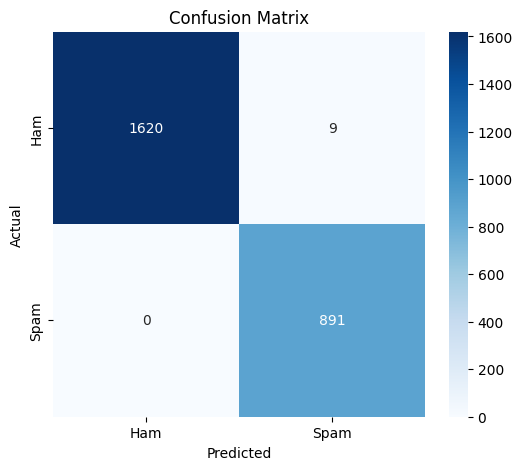

In [14]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 2. Feature Importance (Random Forest)

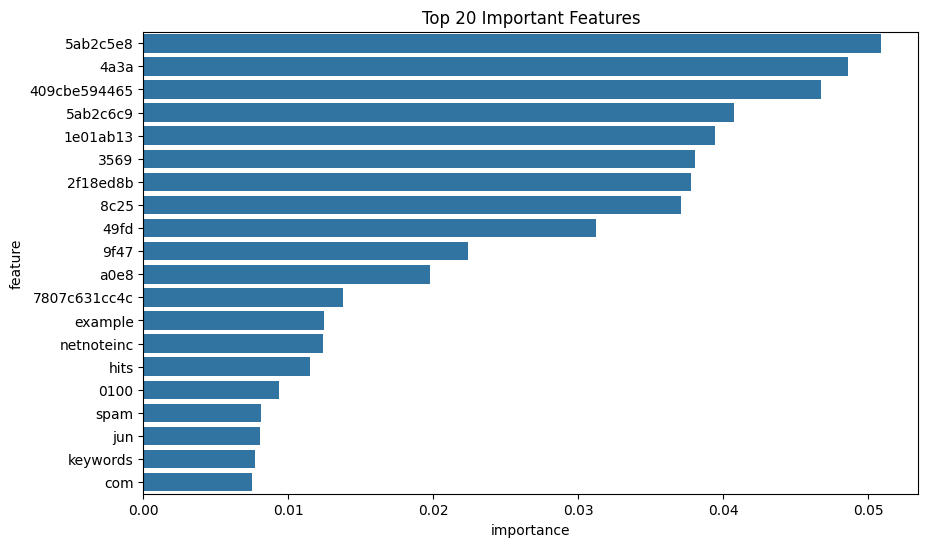

In [17]:
feature_importance = rf_model.feature_importances_
features = vectorizer.get_feature_names_out()

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importance
})

# Sort by importance
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Plot the top 20 most important features
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df.head(20))
plt.title('Top 20 Important Features')
plt.show()


## **Random predictions**

In [26]:
import random

# Step 1: Randomly select 5 indices from the test set
random_indices = random.sample(range(X_test.shape[0]), 5)  # Use shape[0] for number of samples

# Step 2: Select the corresponding raw text and actual labels
sample_text = [X_test[i] for i in random_indices]  # Use raw email text
actual_labels = y_test.iloc[random_indices]  # Use .iloc to index by position

# Step 3: Make predictions using the Random Forest model
predictions = rf_model.predict(X_test[random_indices])

# Step 4: Display the random predictions and actual labels
for i in range(len(random_indices)):
    print(f"Sample {i+1}:")
    print(f"Text: {sample_text[i]}")  # Show the actual email text
    print(f"Actual Label: {'Spam' if actual_labels.iloc[i] == 1 else 'Ham'}")
    print(f"Predicted Label: {'Spam' if predictions[i] == 1 else 'Ham'}\n")


Sample 1:
Text:   (0, 1310)	9
  (0, 288)	5
  (0, 459)	1
  (0, 201)	7
  (0, 3902)	1
  (0, 3411)	1
  (0, 1582)	1
  (0, 4985)	2
  (0, 2890)	6
  (0, 3213)	2
  (0, 3791)	4
  (0, 95)	2
  (0, 3465)	2
  (0, 2762)	1
  (0, 3558)	1
  (0, 1913)	2
  (0, 2493)	3
  (0, 2681)	3
  (0, 31)	3
  (0, 1802)	1
  (0, 2525)	1
  (0, 2064)	1
  (0, 4164)	1
  (0, 1730)	1
  (0, 22)	2
  :	:
  (0, 3890)	3
  (0, 1401)	1
  (0, 1068)	1
  (0, 2381)	1
  (0, 2382)	1
  (0, 317)	1
  (0, 157)	1
  (0, 166)	1
  (0, 4166)	2
  (0, 2261)	2
  (0, 1014)	2
  (0, 2925)	7
  (0, 451)	1
  (0, 694)	2
  (0, 568)	1
  (0, 4773)	2
  (0, 1155)	2
  (0, 2652)	2
  (0, 3943)	2
  (0, 1984)	2
  (0, 542)	2
  (0, 14)	2
  (0, 4602)	2
  (0, 4786)	2
  (0, 2982)	3
Actual Label: Spam
Predicted Label: Spam

Sample 2:
Text:   (0, 661)	4
  (0, 1310)	6
  (0, 54)	2
  (0, 201)	9
  (0, 3902)	1
  (0, 3411)	1
  (0, 1944)	3
  (0, 1582)	2
  (0, 2890)	7
  (0, 3791)	6
  (0, 95)	3
  (0, 3558)	4
  (0, 1913)	4
  (0, 2493)	7
  (0, 2525)	1
  (0, 2064)	1
  (0, 4164)	1
  (0, 